In [1]:
import pandas as pd
import numpy as np
from functools import partial
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm as tqdm
import lightgbm as lgb
import re
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt

In [102]:
pd.set_option("max_columns",100)
pd.set_option("max_rows",50)

In [4]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:75% !important; }</style>"))

In [2]:
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus']=False

# 读取数据

>train_job：265690条记录

> test_user：500条记录  
 test_action：40359条记录   其中有36717条在train_job中找到


> train_user：4500条记录  
train_action：700938条记录   其中有638731条在train_job中找到


In [3]:
test_user = pd.read_csv(r"C:\Users\ZHOU-JC\Desktop\zhaopin_round1_test_20190716\user_ToBePredicted",delimiter="\t")
test_action = pd.read_csv(r"C:\Users\ZHOU-JC\Desktop\zhaopin_round1_user_exposure_B_20190819",delim_whitespace=True)

####
train_user = pd.read_csv(r"C:\Users\ZHOU-JC\Desktop\zhaopin_round1_train_20190716\table1_user",delimiter="\t")
train_job = pd.read_csv(r"C:\Users\ZHOU-JC\Desktop\zhaopin_round1_train_20190716\table2_jd",delimiter="\t",error_bad_lines=False)
train_action = pd.read_csv(r"C:\Users\ZHOU-JC\Desktop\zhaopin_round1_train_20190716\table3_action",delimiter="\t")

#重点
# train_action = train_action.groupby(['user_id', 'jd_no'], as_index=False).sum()

test_big_table = pd.merge(test_action,test_user,how="inner",on="user_id")
test_big_table = pd.merge(test_big_table,train_job,how="inner",on="jd_no")
big_table = pd.merge(train_action,train_user,how="inner",on="user_id")
big_table = pd.merge(big_table,train_job,how="inner",on="jd_no")

b'Skipping line 173315: expected 18 fields, saw 20\n'
D:\software\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (8,9) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [255]:
train_user.to_excel(r"C:\Users\ZHOU-JC\Desktop\求职表.xlsx",index=False)

In [85]:
big_table.loc[:20000].to_excel(r"C:\Users\ZHOU-JC\big_table.xlsx", index=False)

In [82]:
beifen = big_table.copy()

In [90]:
beifen[(beifen['user_id'] == '00287206099a0da696f55174cfe2b771') & (beifen['jd_no'] == 'ad03a27715cd1f71df9d7c02b919eabe')]

,user_id,jd_no,browsed,delivered,satisfied,live_city_id,desire_jd_city_id,desire_jd_industry_id,desire_jd_type_id,desire_jd_salary_id,cur_industry_id,cur_jd_type,cur_salary_id,cur_degree_id,birthday,start_work_date,experience,jd_title,company_name,city,jd_sub_type,require_nums,max_salary,min_salary,start_date,end_date,is_travel,min_years,key,min_edu_level,max_edu_level,is_mangerial,resume_language_required,job_description,desire_jd_city_1,desire_jd_city_2,desire_jd_city_3,city_equal_live_city,city_equal_desired_city_1,city_equal_desired_city_2,city_equal_desired_city_3,job_description_len,experience_num,exp_in_desc_num,岗位描述长度分箱,desire_jd_industry_id_in_jub_describe,desire_jd_type_id_in_jub_describe,cur_jd_type_in_jub_describe,cur_industry_id_in_jub_describe,desire_jd_industry_id_in_jd_title,desire_jd_type_id_in_jd_title,cur_jd_type_in_jd_title,cur_industry_id_in_jd_title,desire_jd_industry_id_in_jd_sub_type,desire_jd_type_id_in_jd_sub_type,cur_jd_type_in_jd_sub_type,cur_industry_id_in_jd_sub_type,工作年龄要求,work_years,work_years_statisfied,word_year_minus_工作年龄要求,satisfied_edu,desire_min_salary,desire_max_salary,desire_salary_diff,min_salary_large_than_desire,max_salary_large_than_desire,cur_salary_min,cur_salary_max,min_salary_large_than_cur,max_salary_large_than_cur,浏览数,job_description_is_null
10735,00287206099a0da696f55174cfe2b771,ad03a27715cd1f71df9d7c02b919eabe,1,0,0,613,"613,-,-","[房地产, 建筑, 建材, 工程]",[工程资料管理],600108000,"[房地产, 建筑, 建材, 工程]","[土木, 建筑, 装修, 市政工程]",0400106000,4,27,2010,投资|资料员|新能源,材料员,-,613,工程资料管理,0,8000,6001,20190320,20190419,1,0,NaN,0,\N,\N,NaN,岗位职责：具备根据材料的外观、质感、采用简单的检验方法，可判断材料的质量是否符合质量要求，以...,613,-1,-1,True,True,False,False,142,3,0,0,1,0,0,1,0,0,0,0,1,1,0,1,3,9,True,6,True,6000,8000,2000,True,True,4000,6000,True,True,1,False


# 杂想

## 是否浏览越多越不会投递

In [578]:
tmp = train_action.groupby(['user_id','jd_no'],as_index=False).agg({'delivered':'count'})
tmp = tmp.rename(columns={"delivered":"浏览数"})
tmp = pd.merge(train_action, tmp, on=['user_id','jd_no'], how='left')

tmp1 = train_action.loc[train_action.delivered == 1, ['user_id','jd_no']]
tmp1['是否投递'] = '是'

tmp = pd.merge(tmp, tmp1, on=['user_id','jd_no'], how='left')
tmp['是否投递'] = tmp['是否投递'].fillna("否")
tmp = tmp.drop_duplicates(['user_id','jd_no'])
tmp['是否投递'] = tmp['是否投递'].apply(lambda x:1 if x=='是' else 0)
tmp = tmp[['user_id', 'jd_no', '浏览数']]

In [580]:
tmp = tmp[['user_id', 'jd_no', '浏览数']]
tmp.shape

(510356, 3)

In [58]:
pd.pivot_table(tmp, index=['浏览数'], values=['是否投递'], )

,是否投递
浏览数,
1,0.133387
2,0.129640
3,0.103111
4,0.091230
5,0.082459
6,0.073776
7,0.074545
8,0.054455
9,0.048544


## 是否浏览越多越不会满意

In [64]:
tmp = train_action.groupby(['user_id','jd_no'],as_index=False).agg({'satisfied':'count'})
tmp = tmp.rename(columns={"satisfied":"浏览数"})
tmp = pd.merge(train_action, tmp, on=['user_id','jd_no'], how='left')

tmp1 = train_action.loc[train_action.satisfied == 1, ['user_id','jd_no']]
tmp1['是否满意'] = '是'

tmp = pd.merge(tmp, tmp1, on=['user_id','jd_no'], how='left')
tmp['是否满意'] = tmp['是否满意'].fillna("否")
tmp = tmp.drop_duplicates(['user_id','jd_no'])
tmp['是否满意'] = tmp['是否满意'].apply(lambda x:1 if x=='是' else 0)

In [66]:
pd.pivot_table(tmp, index=['浏览数'], values=['是否满意'], )

,是否满意
浏览数,
1,0.061008
2,0.070162
3,0.062264
4,0.058924
5,0.055361
6,0.046019
7,0.060000
8,0.049505
9,0.048544


## 对jd进行发掘


In [136]:
tmp = train_action.groupby('jd_no', as_index=False).agg({"delivered":["mean", "count"]})

tmp = tmp[tmp[('delivered', 'count')] > 30]
tmp = pd.merge(tmp, train_job, on='jd_no', how='left')
tmp = tmp.sort_values(by=('delivered', 'mean'), ascending=False)
tmp.to_excel(r"C:\Users\ZHOU-JC\Desktop\jd_no挖掘.xlsx", index=False)

D:\software\Anaconda3\lib\site-packages\pandas\core\reshape\merge.py:522: UserWarning: merging between different levels can give an unintended result (2 levels on the left, 1 on the right)
  warnings.warn(msg, UserWarning)


In [ ]:
tmp = train_action.groupby('jd_no', as_index=False).agg({"delivered":["mean", "count"]})

# 职位表

In [26]:
train_job.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 265690 entries, 0 to 265689
Data columns (total 18 columns):
jd_no                       265690 non-null object
jd_title                    265690 non-null object
company_name                265690 non-null object
city                        265690 non-null int64
jd_sub_type                 265690 non-null object
require_nums                265690 non-null int64
max_salary                  265690 non-null int64
min_salary                  265690 non-null int64
start_date                  265690 non-null object
end_date                    265690 non-null object
is_travel                   265690 non-null int64
min_years                   265690 non-null int64
key                         3056 non-null object
min_edu_level               265690 non-null object
max_edu_level               265690 non-null object
is_mangerial                265690 non-null object
resume_language_required    4961 non-null object
job_description             2656

## 职位代码jb_no
共有265690个职位 

In [27]:
train_job.jd_no.nunique()      

265690

## 

## 职位标题jd_title
>共125302个title  
前三名为：  
会计  
出纳  
土建工程师  

In [143]:
train_job.jd_title.value_counts()

会计                             5263
出纳                             2573
土建工程师                          2254
人事专员                           2118
行政专员                           1786
项目经理                           1417
总经理助理                          1383
施工员                            1338
资料员                            1234
财务会计                           1178
销售经理                           1164
财务经理                           1162
行政助理                           1159
文员                             1010
人事行政专员                          971
行政前台                            969
行政主管                            900
行政文员                            834
办公室文员                           832
人力资源专员                          812
司机                              778
会计助理                            772
人力资源经理                          727
预算员                             687
销售内勤                            682
销售代表                            661
置业顾问                            655
财务助理                        

## 城市city
共有393个城市

In [158]:
tmp = pd.merge(train_action, train_job, on='jd_no', how='left')
tmp = tmp.groupby('city', as_index=False).agg({'delivered':'mean', 'satisfied':'count'})
tmp = tmp.rename(columns={'satisfied':'该城市投递数'})

In [165]:
tmp.sort_values('delivered', ascending=False)

,city,delivered,该城市投递数
140,679.0,1.000000,1
365,10140.0,1.000000,1
30,539.0,1.000000,1
376,10184.0,1.000000,1
132,670.0,1.000000,1
358,10059.0,1.000000,1
350,936.0,1.000000,1
314,866.0,1.000000,1
129,667.0,0.666667,3
6,495.0,0.500000,2


## 职位子类jd_sub_type
806个职位之类

In [168]:
train_job.jd_sub_type.nunique()

806

In [169]:
train_job.jd_sub_type.value_counts()

\N                 35674
会计/会计师             10562
行政专员/助理            10482
助理/秘书/文员            8920
工程造价/预结算            8312
人力资源专员/助理           7691
其他                  7230
出纳员                 5296
行政经理/主管/办公室主任       4402
前台/总机/接待            3808
建筑施工现场管理            3583
机动车司机/驾驶            3252
施工员                 3211
教学/教务管理人员           2995
人力资源经理              2862
室内装潢设计              2797
采购专员/助理             2763
人力资源主管              2755
项目经理/项目主管           2638
工程资料管理              2530
客户服务专员/助理           2434
财务助理                2388
房地产销售/置业顾问          2378
小学教师                2371
培训/招生/课程顾问          2216
财务经理                2159
幼教                  2123
会计助理/文员             2040
财务主管/总帐主管           1999
总裁助理/总经理助理          1911
招聘专员/助理             1762
平面设计                1744
工程监理/质量管理           1724
文档/资料管理             1650
房地产项目管理             1619
区域销售经理/主管           1613
后勤人员                1484
高级建筑工程师/总工          1449
网络/在线客服             1444
物业经理/主管             1387


## 需求人数 require_nums

需求人数越高 投递率越低

## 最低月薪min_salary
最低月薪越高 投递率越高?

## 最高月薪max_salary

## 是否要求出差is_travel

In [139]:
train_job.is_travel.value_counts()

0    166782
1     97640
2      1268
Name: is_travel, dtype: int64

## 工作年限min_years
> -1 的投递率为9.3&    
1 的投递率大概为8.2%   
3 的投递率 8#   
5的投递率 9.4%   
10的投递率为13.4%   

In [177]:
train_job.min_years.value_counts()

-1       93693
 103     75527
 305     50505
 510     29845
 1099     5498
 1        5430
 0        5161
 399        26
 599         2
 199         1
 110         1
 299         1
Name: min_years, dtype: int64

## 最低学历min_edu_level
最低学历要求越低 投递率越高

In [141]:
train_job.min_edu_level.value_counts()

大专     128135
本科      83313
\N      38126
中专      11938
硕士       1503
中技       1404
高中       1259
博士         10
初中          1
请选择         1
Name: min_edu_level, dtype: int64

## 职位描述job_description

工作描述为\N的投递率低

In [183]:
train_job.job_description.nunique()

243774

## 待定变量

### 开始日期start_date

### 结束日期end_date

## 无用变量

### 关键字key
仅有3056个为非空

### 公司company_name
无用

### 是否要求管理经验is_mangerial
无用

In [127]:
train_job.is_mangerial.unique()

array(['\\N'], dtype=object)

### 语言需求resume_language_required

### 最高学历max_edu_level

# 求职者表

## 用户表示user_id  
共4500个求职者  

In [186]:
train_user.user_id.nunique()

4500

## 现居住地live_city_id  

共240个居住地   

In [187]:
train_user.live_city_id.nunique()

240

## 期望工作城市desire_jd_city_id
构造第一期望工作城市、第二期望工作城市、第三期望工作城市  

In [189]:
train_user.desire_jd_city_id.unique()

array(['551,-,-', '763,-,-', '530,-,-', '5085,-,-', '719,-,-', '639,-,-',
       '854,-,-', '613,-,-', '627,-,-', '691,698,-', '765,-,-',
       '606,765,682', '517,930,529', '854,552,-', '565,-,-', '653,-,-',
       '533,-,-', '599,-,-', '801,-,-', '831,-,-', '538,-,-', '531,-,-',
       '574,530,530', '636,-,-', '574,531,-', '702,-,-', '637,-,-',
       '530,531,532', '703,-,-', '548,-,-', '570,530,-', '765,765,765',
       '726,719,-', '548,541,539', '534,-,-', '600,-,-', '622,-,-',
       '635,-,-', '854,857,-', '574,-,-', '749,-,-', '532,-,-', '576,-,-',
       '539,544,530', '613,599,-', '3987,-,-', '552,-,-', '736,-,-',
       '823,828,822', '732,-,-', '599,530,535', '557,-,-', '801,801,-',
       '545,-,-', '539,538,-', '748,551,801', '718,-,-', '763,768,-',
       '691,-,-', '599,613,-', '707,-,-', '765,765,-', '545,556,530',
       '813,804,810', '535,-,-', '587,-,-', '530,531,-', '749,765,765',
       '822,-,-', '763,763,763', '601,599,-', '801,805,-', '545,719,-',
       '7

## 期望行业desire_jd_industry_id
构造特征：期望行业与职位匹配程度  
有1705种

In [191]:
train_user.desire_jd_industry_id.nunique()

1705

In [190]:
train_user.desire_jd_industry_id

0                                            房地产/建筑/建材/工程
1                                                      其他
2                           专业服务/咨询(财会/法律/人力资源等),教育/培训/院校
3                                            房地产/建筑/建材/工程
4               礼品/玩具/工艺美术/收藏品/奢侈品,教育/培训/院校,媒体/出版/影视/文化传播
5                                                教育/培训/院校
6              专业服务/咨询(财会/法律/人力资源等),石油/石化/化工,房地产/建筑/建材/工程
7                       房地产/建筑/建材/工程,加工制造（原料加工/模具）,贸易/进出口
8                                            房地产/建筑/建材/工程
9                                                教育/培训/院校
10      房地产/建筑/建材/工程,快速消费品（食品/饮料/烟酒/日化）,耐用消费品（服饰/纺织/皮革...
11                      政府/公共事业/非盈利机构,房地产/建筑/建材/工程,贸易/进出口
12                                                房地产|建筑业
13                   银行,房地产/建筑/建材/工程,专业服务/咨询(财会/法律/人力资源等)
14                                           房地产/建筑/建材/工程
15                            交通/运输,教育/培训/院校,家居/室内设计/装饰装潢
16                          房地产/建筑/建材/工程,物业管理/商业中心,贸易/进出口
17            

## 期望职类desire_jd_type_id
有2815种

In [196]:
train_user

,user_id,live_city_id,desire_jd_city_id,desire_jd_industry_id,desire_jd_type_id,desire_jd_salary_id,cur_industry_id,cur_jd_type,cur_salary_id,cur_degree_id,birthday,start_work_date,experience
0,17e1b9f107dd1214bd78dec6d91593a4,551,"551,-,-",房地产/建筑/建材/工程,工程造价/预结算,100002000,房地产/建筑/建材/工程,土木/建筑/装修/市政工程,0200104000,大专,24,2017,停车|现场|凤凰|预算编制|建设|实习|专家|公园|预算软件|勘察|合同|知识|商务|单位|...
1,0c02d9411e83ae0308cdc40700385d4c,763,"763,-,-",其他,化妆师,400106000,房地产/建筑/建材/工程,后期制作,0400106000,大专,24,2015,调色员|彩妆|护肤|布料|光源|客户|调色
2,1f4504451a08e1e99e0b394e03f24b43,530,"530,-,-","专业服务/咨询(财会/法律/人力资源等),教育/培训/院校","项目经理/项目主管,教学/教务管理人员,翻译（口译与笔译）",0,教育/培训/院校,项目管理/项目协调,1000115000,本科,33,2010,互联网参考模型osi七层|建设|英语|项目主管|签证|谈判|合同|crm系统|pl/sql|...
3,127b43572875dea9ed858da73a651433,871,"5085,-,-",房地产/建筑/建材/工程,行政/后勤/文秘,200104000,旅游/度假,行政/后勤/文秘,0200104000,大专,24,2017,行政|酒店|后勤|温泉|文员|文秘|旅游
4,15c607e1798305fb9f2e525d964a1185,530,"530,-,-","礼品/玩具/工艺美术/收藏品/奢侈品,教育/培训/院校,媒体/出版/影视/文化传播","艺术/设计,教育/培训",600108000,广告/会展/公关,艺术/设计,0600108000,大专,24,2015,上色|产品开发|插画|纸张|老师|制作|3dmax|美术|视觉设计|视觉|vi|道具|设计师...
5,2e1fa5384caaa1757dc2db8d5b44c5cf,719,"719,-,-",教育/培训/院校,"教学/教务管理人员,销售行政专员/助理,后勤人员",600108000,房地产/建筑/建材/工程,外贸/贸易专员/助理,0200104000,本科,33,2007,计划|预算|外国语言文学|公司财务|预定|入库|对账|橱柜|分销商|系统|业务|保证|售后服...
6,08b7a0e07cc0d8213cc4da58db2db590,763,"763,-,-","专业服务/咨询(财会/法律/人力资源等),石油/石化/化工,房地产/建筑/建材/工程","会计/会计师,固定资产会计,税务专员/助理",800110000,房地产/建筑/建材/工程,财务/审计/税务,0600108000,本科,27,2014,催收|预算|银行|报税|做账|财务软件|处理|预算软件|会计工作|金蝶财务|办公室|说明书|...
7,1e6370900df60e46e4d3a7564943c00b,639,"639,-,-","房地产/建筑/建材/工程,加工制造（原料加工/模具）,贸易/进出口","销售业务,财务/审计/税务,采购/贸易",0,物业管理/商业中心,销售管理,0400106000,本科,21,2016,园林|互联网参考模型osi七层|文件|风险|处理|风控|接待|清洁|自我评价|投诉|设备|收...
8,05b8622d1cac25339b43b39c52fa9a19,854,"854,-,-",房地产/建筑/建材/工程,"行政专员/助理,助理/秘书/文员",200104000,汽车/摩托车,NaN,0200104000,大专,24,2015,外科|自我评价|人力资源专员|助理|人力资源管理|吃苦|行政助理|汽修|人力资源|汽车检测与维修
9,03aa33f2c60d24171ff00c19ae275ae8,613,"613,-,-",教育/培训/院校,行政专员/助理,800110000,酒店/餐饮,NaN,0600108000,大专,21,2016,担当|行政专员|助理


## 最近工作行业cur_jd_type
178种  

In [204]:
train_user.cur_jd_type.value_counts()

土木/建筑/装修/市政工程     437
财务/审计/税务          270
行政/后勤/文秘          225
教育/培训             199
人力资源              172
项目管理/项目协调         133
销售业务              130
销售管理              127
房地产开发/经纪/中介       114
高级管理               80
市场                 58
其他                 47
采购/贸易              45
客服/售前/售后技术支持       40
销售行政/商务            32
商超/酒店/娱乐管理/服务      30
艺术/设计              28
质量管理/安全防护          25
物流/仓储              21
影视/媒体/出版/印刷        18
交通运输服务             18
生产管理/运营            16
助理/秘书/文员           16
生物/制药/医疗器械         16
翻译（口译与笔译）          13
实习生/培训生/储备干部       13
行政专员/助理            12
培训/招生/课程顾问         12
技工/操作工             11
工程造价/预结算           11
广告/会展              11
人力资源专员/助理          11
物业管理               10
咨询/顾问/调研/数据分析      10
教学/教务管理人员          10
前台/总机/接待            9
公务员/事业单位/科研机构       9
银行                  9
兼职/临时               9
建筑施工现场管理            8
出纳员                 8
外语教师                8
保险                  8
小学教师                7
律师/法务/合规            7
项目经理/项目主管 

## 最近工作职类cur_industry_id  
共56种

In [206]:
train_user.cur_industry_id.nunique()

56

## 期望薪水desire_jd_salary_id

In [199]:
train_user.desire_jd_salary_id.value_counts()

400106000       1392
600108000        870
0                592
800110000        440
200104000        430
1000115000       408
1500125000       244
2500199999        63
3500150000        24
70001100000        9
100002000          8
1000               8
100001150000       5
5000170000         5
2500135000         2
Name: desire_jd_salary_id, dtype: int64

## 最近薪水cur_salary_id

In [208]:
train_user.cur_salary_id.value_counts()

0400106000      1316
0200104000      1040
0600108000       755
1000115000       439
0800110000       413
1500125000       234
0000001000        72
2500199999        67
0100002000        63
3500150000        33
-                 31
0000000000        15
5000170000        12
70001100000        5
100001150000       5
Name: cur_salary_id, dtype: int64

## 学历cur_degree_id

In [210]:
train_user.cur_degree_id.value_counts()

本科      2254
大专      1672
硕士       138
高中       106
中专        99
MBA       16
其他        12
中技        11
EMBA       6
初中         6
博士         1
Name: cur_degree_id, dtype: int64

## 年龄(虚拟年龄)birthday

In [211]:
train_user.birthday

0       24
1       24
2       33
3       24
4       24
5       33
6       27
7       21
8       24
9       21
10      27
11      30
12      27
13      27
14      30
15      27
16      27
17      33
18      30
19      24
20      30
21      21
22      27
23      27
24      21
25      24
26      36
27      21
28      27
29      24
30      27
31      27
32      27
33      33
34      30
35      21
36      27
37      24
38      24
39      39
40      21
41      24
42      21
43      33
44      27
45      24
46      21
47      24
48      24
49      27
50      21
51      24
52      36
53      24
54      24
55      33
56      24
57      27
58      24
59      33
60      24
61      24
62      24
63      27
64      30
65      24
66      27
67      21
68      39
69      36
70      30
71      36
72      24
73      27
74      27
75      21
76      21
77      24
78      30
79      21
80      33
81      27
82      24
83      21
84      24
85      24
86      24
87      24
88      24
89      24
90      24

## 开始工作时间start_work_date
职位表的开始日期-开始工作时间 = 个人工作年龄

In [221]:
train_user.start_work_date.isnull().sum()

0

## 经验experience
每个人的经验都不同，4464


In [217]:
train_user.experience.nunique()

4464

# 特征处理

## 对require_nums分箱处理

In [4]:
big_table['require_nums'] = pd.qcut(big_table['require_nums'], q=4, labels=range(3), duplicates='drop')

## 匹配：城市

In [5]:
def extract_city(citys,index):
    city_list = citys.split(",")
    if index < len(city_list):
        city = city_list[index]
        if city != "-":
            city = int(city)
        else:
            city = -1
    else:
        city = -1
    return city

In [6]:
for df in [big_table]:
    #工作城市的匹配
    df["desire_jd_city_1"]   = df["desire_jd_city_id"].apply(partial(extract_city,index=0))
    df["desire_jd_city_2"]   = df["desire_jd_city_id"].apply(partial(extract_city,index=1))
    df["desire_jd_city_3"]   = df["desire_jd_city_id"].apply(partial(extract_city,index=2))
    df["city_equal_live_city"]      = df["live_city_id"]==df["city"]
    df["city_equal_desired_city_1"] = df["desire_jd_city_1"]==df["city"]
    df["city_equal_desired_city_2"] = df["desire_jd_city_2"]==df["city"]
    df["city_equal_desired_city_3"] = df["desire_jd_city_3"]==df["city"]
print("工作城市匹配完成")

工作城市匹配完成


## 匹配：工作经验
返回的是被认可的经验个数

In [7]:
def exp_in_desc(exp,desc):
    if str(exp) == "nan":
        exp = ""
    exps = exp.split("|")
    num = 0
    for item in exps:
        if item in desc:
            num+=1
    return num

In [8]:
for df in [big_table]:
    #经验符合工作描述的匹配
    df["job_description_len"] = df["job_description"].apply(len)
    df["experience_num"] = df["experience"].apply(lambda x: len(str(x).split("|")) if str(x) != "nan" else 0)
    exp_in_desc_num = []
    for idx, data in df.iterrows():
        exp_in_desc_num.append(exp_in_desc(data["experience"],data["job_description"]))
    df["exp_in_desc_num"] = exp_in_desc_num
#     df['岗位描述长度分箱'] = pd.qcut(df['job_description_len'], q=4, labels=range(3))
print("经验匹配完成")

经验匹配完成


In [9]:
big_table['experience_num_cut'] = pd.qcut(
    big_table["experience_num"], q=5, labels=range(5)) 
big_table['岗位描述长度分箱'] = pd.qcut(
    big_table['job_description_len'], q=5, labels=range(5))

In [10]:
big_table['job_description_is_null'] = big_table['job_description'].apply(lambda x : True if len(x) < 4 else False)

In [11]:
big_table['desire_jd_industry_id'] = big_table.desire_jd_industry_id.apply(lambda x : re.split('/|,', x))
big_table['desire_jd_type_id'] =  big_table.desire_jd_type_id.apply(lambda x:re.split('/|,', x))
big_table['cur_jd_type'] = big_table.cur_jd_type.apply(lambda x:re.split("/|,", x) if isinstance(x,str) else [])
big_table['cur_industry_id'] = big_table.cur_industry_id.apply(lambda x:re.split("/|,", x) if isinstance(x,str) else [])

In [12]:
big_table['desire_jd_industry_id_in_jub_describe'] = big_table.apply(lambda x:len([each for each in x['desire_jd_industry_id'] if each in x['job_description']]), axis=1)
big_table['desire_jd_type_id_in_jub_describe'] = big_table.apply(lambda x:len([each for each in x['desire_jd_type_id'] if each in x['job_description']]), axis=1)
big_table['cur_jd_type_in_jub_describe'] =       big_table.apply(lambda x:len([each for each in x['cur_jd_type']       if each in x['job_description']]), axis=1)
big_table['cur_industry_id_in_jub_describe'] = big_table.apply(lambda x:len([each for each in x['cur_industry_id'] if each in x['job_description']]), axis=1)

In [13]:
big_table['desire_jd_industry_id_in_jd_title'] = big_table.apply(lambda x:len([each for each in x['desire_jd_industry_id'] if each in x['jd_title']]), axis=1)
big_table['desire_jd_type_id_in_jd_title'] = big_table.apply(lambda x:len([each for each in x['desire_jd_type_id'] if each in x['jd_title']]), axis=1)
big_table['cur_jd_type_in_jd_title'] = big_table.apply(lambda x:len([each for each in x['cur_jd_type'] if each in x['jd_title']]), axis=1)
big_table['cur_industry_id_in_jd_title'] = big_table.apply(lambda x:len([each for each in x['cur_industry_id'] if each in x['jd_title']]), axis=1)

In [14]:
big_table['desire_jd_industry_id_in_jd_sub_type'] = big_table.apply(lambda x:len([each for each in x['desire_jd_industry_id'] if each in x['jd_sub_type']]), axis=1)
big_table['desire_jd_type_id_in_jd_sub_type'] = big_table.apply(lambda x:len([each for each in x['desire_jd_type_id'] if each in x['jd_sub_type']]), axis=1)
big_table['cur_jd_type_in_jd_sub_type'] = big_table.apply(lambda x:len([each for each in x['cur_jd_type'] if each in x['jd_sub_type']]), axis=1)
big_table['cur_industry_id_in_jd_sub_type'] = big_table.apply(lambda x:len([each for each in x['cur_industry_id'] if each in x['jd_sub_type']]), axis=1)

In [69]:
big_table.columns

Index(['user_id', 'jd_no', 'browsed', 'delivered', 'satisfied', 'live_city_id',
       'desire_jd_city_id', 'desire_jd_industry_id', 'desire_jd_type_id',
       'desire_jd_salary_id', 'cur_industry_id', 'cur_jd_type',
       'cur_salary_id', 'cur_degree_id', 'birthday', 'start_work_date',
       'experience', 'jd_title', 'company_name', 'city', 'jd_sub_type',
       'require_nums', 'max_salary', 'min_salary', 'start_date', 'end_date',
       'is_travel', 'min_years', 'key', 'min_edu_level', 'max_edu_level',
       'is_mangerial', 'resume_language_required', 'job_description',
       'desire_jd_industry_id_in_jub_describe',
       'desire_jd_type_id_in_jub_describe', 'cur_jd_type_in_jub_describe',
       'cur_industry_id_in_jub_describe', 'desire_jd_industry_id_in_jd_title',
       'desire_jd_type_id_in_jd_title', 'cur_jd_type_in_jd_title',
       'cur_industry_id_in_jd_title', 'desire_jd_industry_id_in_jd_sub_type',
       'desire_jd_type_id_in_jd_sub_type', 'cur_jd_type_in_jd_sub_type

## 匹配：工作年限

In [15]:
min_year_dict = {
    305: 3,
    -1:0,
    0:0,
    1:1,
    103:1,
    199:1,
    110:1,
    299:2,
    399:3,
    510:5,
    599:5,
    1099:10,
    "0":0,
     "1":1,
     "2":2,
     "3":3,
     "4":4,
     "5":5,
     "6":6,
     "7":7,
     "8":8,
     "9":9,
     "10":10,
     "１":1,
     "２":2,
     "３":3,
     "４":4,
     "５":5,
     "６":6,
     "７":7,
     "８":8,
     "一": 1,
     "二": 2,
     "三": 3,
     "四": 4,
     "五": 5,
     "六": 6,
     "七": 7,
     "八": 8,
     "九": 9,
     "十": 10,      
}

In [16]:
#训练集  
for df in [big_table, test_big_table]:
    df["min_years"] = df["min_years"].apply(lambda x: min_year_dict[x])
    ## 再从工作描述提取工作经验要求
    df['工作年龄要求'] = df['job_description'].apply(lambda x: re.search("(\d)?-?([一二三四五六七八九十\d])+年以上", x))
    df['工作年龄要求'] = df['工作年龄要求'].apply(lambda x:-1 if None is x 
                                  else x.group(1) if None is not x.group(1)
                                  else "10" if (x.group(1)=='1' and x.group(2) == '0')
                                  else x.group(2))
    df['工作年龄要求'] = df['工作年龄要求'].apply(lambda x:-1 if -1 is x else min_year_dict[x])
    # 合并
    df['工作年龄要求'] = df.apply(lambda row:row['min_years'] if row['工作年龄要求'] is -1 else row['工作年龄要求'], axis=1)

    df["work_years"] = 2019 - df["start_work_date"].apply(lambda x : 2019 if x=="-" else int(x))
    df["work_years_statisfied"] = df["work_years"].astype(int) > df["工作年龄要求"]
    df['word_year_minus_工作年龄要求'] = df["work_years"] - df["工作年龄要求"]
print("工作年限匹配完成")

工作年限匹配完成


## 匹配：学历

In [17]:
degree_dict = {
    "初中":1,
    "中技":2,
    "高中":3,
    "中专":3,
    "大专":4,
    "本科":5,
    "硕士":6,
    "博士":7,
    "EMBA":7,
    "MBA":7,
    "其他":0,
    "请选择":0,
    "\\N":0,
    "na":0
}

In [18]:
for df in [big_table, test_big_table]:
    #最低学历的匹配
    df["cur_degree_id"] = df["cur_degree_id"].fillna("大专").apply(lambda x:degree_dict[x.strip()])
    df["min_edu_level"] = df["min_edu_level"].fillna("na").apply(lambda x:degree_dict[x.strip()])
    df['satisfied_edu'] = (df["cur_degree_id"] > df["min_edu_level"])
print("学历匹配完成")

学历匹配完成


## 匹配：薪酬

In [156]:
min_salary_dict = {
    0:4,
    1000:1,
    100002000:1,
    200104000:2,
    400106000:4,
    600108000:6,
    800110000:8,
    1000115000:10,
    1500125000:15,
    2500135000:25,
    3500150000:35,
    5000170000:50,
    2500199999:25,
    70001100000:70,
    100001150000:100,
}

max_salary_dict = {
    0:6,
    1000:1,
    100002000:2,
    200104000:4,
    400106000:6,
    600108000:8,
    800110000:10,
    1000115000:15,
    1500125000:25,
    2500135000:35,
    3500150000:50,
    5000170000:70,
    2500199999:100,
    70001100000:100,
    100001150000:150,
}

In [157]:
for df in [big_table, test_big_table]:
    df['min_salary'] = round(df['min_salary']/1000, 0)
    df['max_salary'] = round(df['max_salary']/1000, 0)
    
    df["desire_min_salary"] = df["desire_jd_salary_id"].apply(lambda x: min_salary_dict[x])
    df["desire_max_salary"] = df["desire_jd_salary_id"].apply(lambda x: max_salary_dict[x])
    df["min_salary_large_than_desire"] = (df["min_salary"] >= df["desire_min_salary"]) 
    df["max_salary_large_than_desire"] = (df["max_salary"] >= df["desire_min_salary"])
    
    df["cur_salary_min"] = df["cur_salary_id"].apply(lambda x: min_salary_dict[int(x if str.isnumeric(x) else "0")])
    df["cur_salary_max"] = df["cur_salary_id"].apply(lambda x: max_salary_dict[int(x if str.isnumeric(x) else "0")])
    df["min_salary_large_than_cur"] =  (df["min_salary"] >= df["cur_salary_min"])
    df["max_salary_large_than_cur"] =  (df["max_salary"] >= df["cur_salary_min"])
    
    df["desire_salary_diff"] = df["desire_max_salary"]-df["desire_min_salary"]
    df["min_salary_minus_desire_min_salary"] = df['min_salary'] - df['desire_min_salary']
    df["min_salary_minus_cur_salary_min"] = df['min_salary'] - df['cur_salary_min']
    
print("薪酬匹配完成")    

D:\software\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
D:\software\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
D:\software\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docume

薪酬匹配完成


## 浏览数

In [21]:
tmp = big_table.groupby(['user_id','jd_no'],as_index=False).agg({'city':'count'})
tmp = tmp.rename(columns={"city":"浏览数"})
big_table = pd.merge(big_table, tmp, on=['user_id','jd_no'], how='left')

tmp = test_big_table.groupby(['user_id','jd_no'],as_index=False).agg({'city':'count'})
tmp = tmp.rename(columns={"city":"浏览数"})
test_big_table = pd.merge(test_big_table, tmp, on=['user_id','jd_no'], how='left')

## all_big_table融合big_table和test_big_table

In [22]:
all_big_table = pd.concat([big_table,test_big_table])  

D:\software\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


# 开始训练模型

## 挑选特征feature_select

In [23]:
cross_feature_names = []

In [92]:
big_table = beifen.copy()

In [30]:
def feature_select(target,*df_list):
    result = []
    
    # 这些都是字符型特征 
#     cat_features = [
#          "live_city_id",
#          "desire_jd_salary_id",
#          "cur_industry_id",
#          "cur_jd_type",
#          "cur_salary_id",
#          "cur_degree_id",
#          "city",
#          "jd_sub_type",
#          "max_salary",
#          "min_salary",
#          "is_travel",
#          "min_years",
#          "min_edu_level",
#          "desire_jd_city_1",
#          "desire_jd_city_2",
#          "desire_jd_city_3",
#          "work_years_statisfied"
#     ] + cross_feature_names
    
    lbl_dict = {}
#     for f in cat_features:        
#         lbl = LabelEncoder()
#         lbl.fit(all_big_table[f].astype(str))
#         lbl_dict[f] = lbl
        
    print("="*30)
        
        
    # 选择的变量    
    for df in df_list:
        features = [
#                     "cur_salary_id",  #类别
                    "cur_degree_id",  #数字
                    "require_nums",   #数字
                    "max_salary",    #数字
                    "min_salary",    #数字
                    "city_equal_live_city",  #布尔
                    "city_equal_desired_city_1",  #布尔
                    "city_equal_desired_city_2",  #布尔
                    "city_equal_desired_city_3",  #布尔
                    "work_years",  #数字
                    
                    "work_years_statisfied",  #布尔
                    "word_year_minus_工作年龄要求",  #数字
                    "min_salary_large_than_desire",  #布尔
                    "max_salary_large_than_desire",  #布尔
                    "min_salary_large_than_cur",  #布尔
                    "max_salary_large_than_cur",  #布尔
                    "min_salary_minus_desire_min_salary",
                    "min_salary_minus_cur_salary_min",
            
            
                    "satisfied_edu", #布尔
#                     "job_description_len", #数字
#                     "experience_num",  #数字
                    "exp_in_desc_num", #数字
                    "工作年龄要求",  #数字
                    "浏览数", #数字
            
            
            
                    "experience_num_cut",
                    "岗位描述长度分箱", #类别
                    'job_description_is_null',
                    'desire_jd_industry_id_in_jub_describe',
                    'desire_jd_type_id_in_jub_describe', 
                    'cur_jd_type_in_jub_describe',
                    'cur_industry_id_in_jub_describe', 
                    'desire_jd_industry_id_in_jd_title',
                    'desire_jd_type_id_in_jd_title', 
                    'cur_jd_type_in_jd_title',
                    'cur_industry_id_in_jd_title', 
                    'desire_jd_industry_id_in_jd_sub_type',
                    'desire_jd_type_id_in_jd_sub_type', 
                    'cur_jd_type_in_jd_sub_type',
                    'cur_industry_id_in_jd_sub_type',
            
                    'birthday'
            
                     ]
        
        x = df[features]
        if target in df.columns:
            y = df[target]
        else:
            y = None
#         for f in cat_features:
#             if f in x.columns:
#                 lbl = lbl_dict[f]
#                 x[f] = lbl.transform(x[f].astype(str))
        
        
        #增加类别型变量
#         features_categorical = [

#                                 ]
    
#         x[features_categorical] = x[features_categorical].astype('category')
        
        result.append((x,y))
    return result

## 用Rank训练

In [256]:
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split


def cross_validate(target="satisfied",
                    param=dict(n_estimators=1000,
                              metric="map",
                              colsample_bytree=0.2,
                              max_depth=7,
                              importance_type="gain")
                   ,n_folds=5,):
    train_users = big_table["user_id"].unique()
    
    ## 获得训练集和测试集
    train_users, test_users = train_test_split(train_users, test_size=0.15)
    df_test = big_table[big_table["user_id"].isin(test_users)]
    df_test_result = df_test[['user_id','delivered', 'satisfied']]
    df_test = feature_select("satisfied", df_test)[0][0]
    print('测试集的大小为：',df_test.shape)
    
    
    ##  构造训练集和验证集
    folds = KFold(n_folds,shuffle=True,random_state=4)
    models = []
    
    ll = np.zeros(df_test.shape[0])
    for idx,(train_idx,valid_idx) in enumerate(folds.split(train_users)):
        ##########################################################################################################
        target = 'delivered'
        #### 
        t_user = train_users[train_idx]
        train_data = big_table[big_table["user_id"].isin(t_user)]
        #### 剔除异常值
#         train_data = train_data[~train_data['user_id'].isin(user_unusual)]
        
        train_data = train_data.sort_values(by='user_id')
        train_group = train_data.groupby("user_id",as_index=False).count()[target].values
        #### 
        v_user = train_users[valid_idx]
        valid_data = big_table[big_table["user_id"].isin(v_user)]
        valid_data = valid_data.sort_values(by='user_id') 
        valid_group = valid_data.groupby("user_id",as_index=False).count()[target].values
        ####
        result = feature_select(target,train_data,valid_data)
        t_x,t_y = result[0]
        v_x,v_y = result[1]
        
        model = lgb.LGBMRanker(**param)
        print("Fold",idx,"-"*30)
        model.fit(t_x,t_y,
                  group=train_group,                        
                  eval_set=[(t_x,t_y),(v_x,v_y)],                     # - tuple pairs to use as a validation sets for early-stopping.
                  eval_group=[train_group,valid_group],                 # –Group data of eval data
                  early_stopping_rounds=40,
                  verbose=40,   
                  categorical_feature='auto',              # – If True and an evaluation set is used, writes the evaluation progress.
                  callbacks=[lgb.reset_parameter(learning_rate=lambda x: 0.1)]
                 )
        models.append(model)
        l1 = model.predict(df_test)
        
        #################################################################################
        target = 'satisfied'        
        #### 
        t_user = train_users[train_idx]
        train_data = big_table[big_table["user_id"].isin(t_user)]
        
        #### 剔除异常值
        train_data = train_data[~train_data['user_id'].isin(user_unusual)]
#         train_data = train_data[train_data['delivered'] == 1]
        print(train_data.shape)
        ####
        train_data = train_data.sort_values(by='user_id')
        train_group = train_data.groupby("user_id",as_index=False).count()[target].values
        #### 
        v_user = train_users[valid_idx]
        valid_data = big_table[big_table["user_id"].isin(v_user)]
        valid_data = valid_data.sort_values(by='user_id') 
        valid_group = valid_data.groupby("user_id",as_index=False).count()[target].values
        ####
        result = feature_select(target,train_data,valid_data)
        t_x,t_y = result[0]
        v_x,v_y = result[1]
        
        model = lgb.LGBMRanker(**param)
        print("Fold",idx,"-"*30)
        model.fit(t_x,t_y,
                  group=train_group,                        
                  eval_set=[(t_x,t_y),(v_x,v_y)],                     # - tuple pairs to use as a validation sets for early-stopping.
                  eval_group=[train_group,valid_group],                 # –Group data of eval data
                  early_stopping_rounds=80,
                  verbose=40,   
                  categorical_feature='auto',              # – If True and an evaluation set is used, writes the evaluation progress.
                  callbacks=[lgb.reset_parameter(learning_rate=lambda x: 0.1)]
                 )
        models.append(model)
        l2 = model.predict(df_test)

        ####  
        ll = ll + 0.3*l1 + 0.7*l2
        tmp = df_test.copy()
        tmp['predict'] = ll
        tmp = pd.concat((tmp, df_test_result), axis=1)        
        
        
        
        
        
        ## 评价函数
        MAP_FINAL = 0
        MAP_SCORE = {'satisfied':0.7,'delivered':0.3}
        for cc in ['satisfied','delivered']:
            tmp['rank'] = tmp.groupby(['user_id'])['predict'].rank(ascending=False,method='first')
            tmp_score = tmp[tmp[cc]==1]
            tmp_score['rank_1'] = tmp_score.groupby(['user_id'])['rank'].rank(ascending=True,method='first')
            tmp_score['AP'] = tmp_score['rank_1'] / tmp_score['rank']
            MAP = tmp_score.groupby(['user_id'])['AP'].mean().reset_index()['AP'].mean()
            MAP_FINAL = MAP_FINAL + MAP * MAP_SCORE[cc]
            print(cc + 'MAP',MAP)
        print(MAP_FINAL)        
             
#     print("mean score",np.mean(scores))
    return models

## 用回归训练

In [82]:
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split


def cross_validate(target="satisfied",
                    param=dict(n_estimators=1000,
                              metric="map",
                              colsample_bytree=0.2,
                              max_depth=7,
                              importance_type="gain")
                   ,n_folds=5,):
    train_users = big_table["user_id"].unique()
    
    ## 获得训练集和测试集
    train_users, test_users = train_test_split(train_users, test_size=0.15)
    df_test = big_table[big_table["user_id"].isin(test_users)]
    df_test_result = df_test[['user_id','delivered', 'satisfied']]
    df_test = feature_select(target, df_test)[0][0]
    print('测试集的大小为：',df_test.shape)
    
    
    train_data = big_table[big_table["user_id"].isin(train_users)]
    tmp_1 = train_data[train_data['satisfied']==1] 
    num_train_satisfied = (train_data['satisfied']==1).sum()
    print(num_train_satisfied)
    
    List_train = []
    tmp_2 = train_data[train_data['satisfied']!=1] 
    for i in range(20):
        tmp = tmp_2.sample(n = num_train_satisfied) 
        tmp = pd.concat([tmp_1, tmp], axis=0)
        List_train.append(tmp)
        
    
    ll = np.zeros(df_test.shape[0])
    for each in List_train:
        print(each.shape)
        result = feature_select(target, each)
        t_x,t_y = result[0]
        model = lgb.LGBMRegressor(**param)
        print("Fold",idx,"-"*30)
        model.fit(t_x,t_y,
#                   eval_set=[(t_x,t_y),(v_x,v_y)],                     # - tuple pairs to use as a validation sets for early-stopping.
#                   early_stopping_rounds=50,
                  verbose=40,   
                  categorical_feature='auto',              # – If True and an evaluation set is used, writes the evaluation progress.
                  callbacks=[lgb.reset_parameter(learning_rate=lambda x: 0.1)]
                 )
        test_pred = model.predict(df_test)
        
#         print(test_pred)
        ll = ll + test_pred
        
        tmp = df_test.copy()
        tmp['predict'] = ll 
        tmp = pd.concat((tmp, df_test_result), axis=1)
                
        
        ## 评价函数
        MAP_FINAL = 0
        MAP_SCORE = {'satisfied':0.7,'delivered':0.3}
        for cc in ['satisfied','delivered']:
            tmp['rank'] = tmp.groupby(['user_id'])['predict'].rank(ascending=False,method='first')
            tmp_score = tmp[tmp[cc]==1]
            tmp_score['rank_1'] = tmp_score.groupby(['user_id'])['rank'].rank(ascending=True,method='first')
            tmp_score['AP'] = tmp_score['rank_1'] / tmp_score['rank']
            MAP = tmp_score.groupby(['user_id'])['AP'].mean().reset_index()['AP'].mean()
            MAP_FINAL = MAP_FINAL + MAP * MAP_SCORE[cc]
            print(cc + 'MAP',MAP)
        print(MAP_FINAL)     



    return models



## 开始训练

In [258]:
models = cross_validate(target="delivered",
                             param=dict(
                                        n_estimators=400,
                                        learning_rate = 0.1,
#                                         max_depth=4,
#                                         min_data_in_leaf = 50,
                                        subsample  = 0.7,  
                                        colsample_bytree  = 0.7,   #
                                        metric="map",                                        
#                                         importance_type="gain"
                                 
                             ),
                                        n_folds=5)

测试集的大小为： (69392, 37)
Fold 0 ------------------------------
Training until validation scores don't improve for 40 rounds.
[40]	training's map@1: 0.312827	valid_1's map@1: 0.20288
[80]	training's map@1: 0.364856	valid_1's map@1: 0.198953
[120]	training's map@1: 0.404777	valid_1's map@1: 0.201571
Early stopping, best iteration is:
[100]	training's map@1: 0.387435	valid_1's map@1: 0.206806
(160970, 76)
Fold 0 ------------------------------
Training until validation scores don't improve for 80 rounds.
[40]	training's map@1: 0.2302	valid_1's map@1: 0.155759
[80]	training's map@1: 0.302739	valid_1's map@1: 0.150524
[120]	training's map@1: 0.358993	valid_1's map@1: 0.149215
Early stopping, best iteration is:
[43]	training's map@1: 0.234641	valid_1's map@1: 0.158377


D:\software\Anaconda3\lib\site-packages\ipykernel_launcher.py:115: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
D:\software\Anaconda3\lib\site-packages\ipykernel_launcher.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


satisfiedMAP 0.1942976274768374
deliveredMAP 0.23803063743676006
0.20741753046481418
Fold 1 ------------------------------
Training until validation scores don't improve for 40 rounds.
[40]	training's map@1: 0.304319	valid_1's map@1: 0.193717
[80]	training's map@1: 0.354712	valid_1's map@1: 0.189791
Early stopping, best iteration is:
[50]	training's map@1: 0.320681	valid_1's map@1: 0.20288
(152977, 76)
Fold 1 ------------------------------
Training until validation scores don't improve for 80 rounds.
[40]	training's map@1: 0.267487	valid_1's map@1: 0.133508
[80]	training's map@1: 0.320523	valid_1's map@1: 0.141361
[120]	training's map@1: 0.377402	valid_1's map@1: 0.138743
Early stopping, best iteration is:
[46]	training's map@1: 0.275173	valid_1's map@1: 0.147906


D:\software\Anaconda3\lib\site-packages\ipykernel_launcher.py:115: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
D:\software\Anaconda3\lib\site-packages\ipykernel_launcher.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


satisfiedMAP 0.19583506563397024
deliveredMAP 0.24026957989115363
0.20916541991112525
Fold 2 ------------------------------
Training until validation scores don't improve for 40 rounds.
[40]	training's map@1: 0.315445	valid_1's map@1: 0.217277
[80]	training's map@1: 0.373691	valid_1's map@1: 0.215969
[120]	training's map@1: 0.420484	valid_1's map@1: 0.223822
Early stopping, best iteration is:
[117]	training's map@1: 0.415576	valid_1's map@1: 0.231675
(154262, 76)
Fold 2 ------------------------------
Training until validation scores don't improve for 80 rounds.
[40]	training's map@1: 0.260771	valid_1's map@1: 0.15445
[80]	training's map@1: 0.320484	valid_1's map@1: 0.155759
Early stopping, best iteration is:
[5]	training's map@1: 0.146636	valid_1's map@1: 0.172775


D:\software\Anaconda3\lib\site-packages\ipykernel_launcher.py:115: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
D:\software\Anaconda3\lib\site-packages\ipykernel_launcher.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


satisfiedMAP 0.19771796665405564
deliveredMAP 0.24291845922178246
0.21127811442437366
Fold 3 ------------------------------
Training until validation scores don't improve for 40 rounds.
[40]	training's map@1: 0.300393	valid_1's map@1: 0.201571
[80]	training's map@1: 0.357657	valid_1's map@1: 0.197644
[120]	training's map@1: 0.393652	valid_1's map@1: 0.20288
Early stopping, best iteration is:
[101]	training's map@1: 0.374673	valid_1's map@1: 0.210733
(154730, 76)
Fold 3 ------------------------------
Training until validation scores don't improve for 80 rounds.
[40]	training's map@1: 0.248673	valid_1's map@1: 0.145288
[80]	training's map@1: 0.32373	valid_1's map@1: 0.14267
Early stopping, best iteration is:
[9]	training's map@1: 0.169067	valid_1's map@1: 0.158377


D:\software\Anaconda3\lib\site-packages\ipykernel_launcher.py:115: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
D:\software\Anaconda3\lib\site-packages\ipykernel_launcher.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


satisfiedMAP 0.19849424548242073
deliveredMAP 0.24382855154490843
0.212094537301167
Fold 4 ------------------------------
Training until validation scores don't improve for 40 rounds.
[40]	training's map@1: 0.310864	valid_1's map@1: 0.206806
[80]	training's map@1: 0.356021	valid_1's map@1: 0.217277
Early stopping, best iteration is:
[76]	training's map@1: 0.353403	valid_1's map@1: 0.219895
(157349, 76)
Fold 4 ------------------------------
Training until validation scores don't improve for 80 rounds.
[40]	training's map@1: 0.248132	valid_1's map@1: 0.168848
[80]	training's map@1: 0.329596	valid_1's map@1: 0.174084
[120]	training's map@1: 0.382661	valid_1's map@1: 0.170157
[160]	training's map@1: 0.413303	valid_1's map@1: 0.176702
Early stopping, best iteration is:
[82]	training's map@1: 0.329596	valid_1's map@1: 0.176702


D:\software\Anaconda3\lib\site-packages\ipykernel_launcher.py:115: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
D:\software\Anaconda3\lib\site-packages\ipykernel_launcher.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


satisfiedMAP 0.19822213775301206
deliveredMAP 0.24287572281193637
0.21161821327068936


## 特征重要性

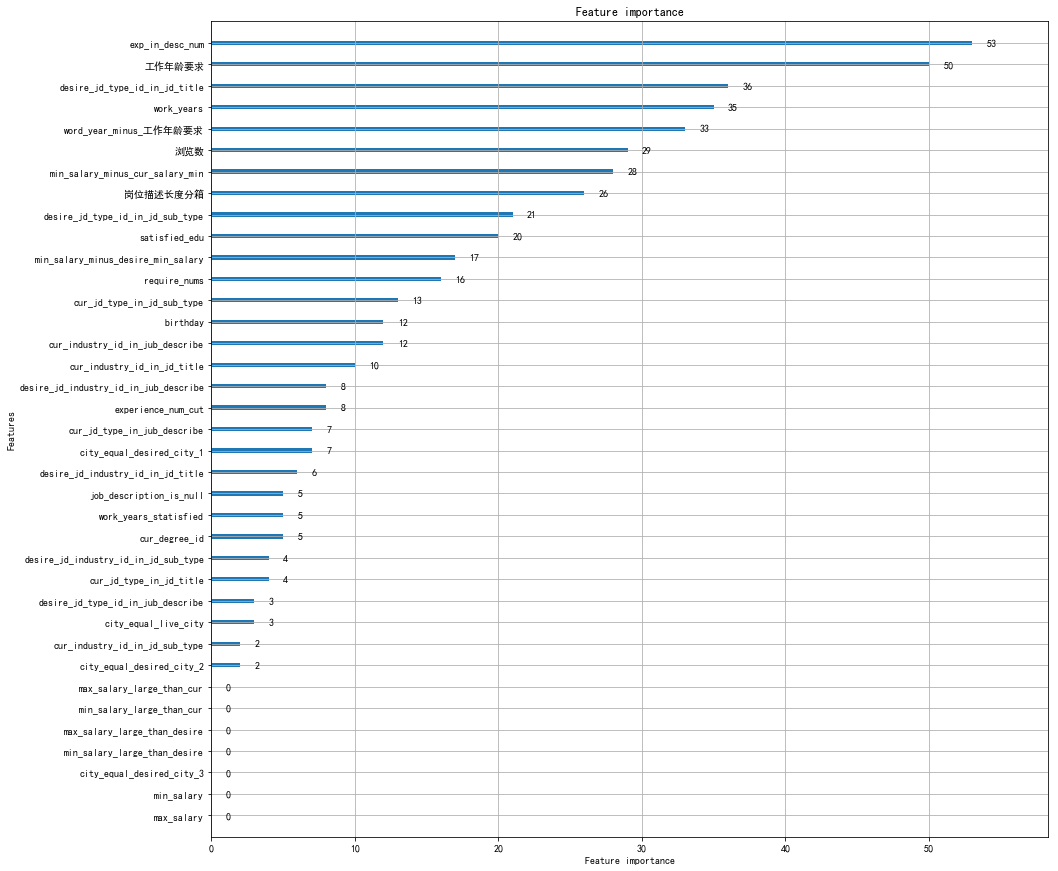

In [248]:
lgb.plot_importance(models[3], 
                    title='Feature importance', 
                    xlabel='Feature importance', 
                    ylabel='Features', 
                    importance_type='split',
                    figsize=(15,15),
                    ignore_zero=False)

# 提交结果

In [ ]:
submit = test_big_table[["user_id","jd_no"]]
submit["score"] = pred
submit = submit.reset_index(drop=True)
result = pd.merge(test_action,submit,how="left",on=["user_id","jd_no"])
result.fillna(-100,inplace=True)
result = result.groupby("user_id",as_index=False).apply(lambda x:x.sort_values("score",ascending=False))
# 需要对结果进行去重
result[["user_id","jd_no"]].drop_duplicates().to_csv("submission.csv",index=False)

In [91]:
big_table.shape

(466163, 76)

## 筛选异常值

In [259]:
tmp = big_table.groupby('user_id').agg({"delivered":[np.sum, 'count'], "browsed":[np.sum, 'count']})

In [262]:
tmp['浏览率率'] = tmp['browsed']['sum'] / tmp['browsed']['count']
tmp = tmp.sort_values(by='浏览率率')
# user_unusual = tmp[(tmp['浏览率率']<0.06) | (tmp['浏览率率']>0.14)]['user_id']

tmp['投递率'] = tmp['delivered']['sum'] / tmp['delivered']['count']
tmp = tmp.sort_values(by='投递率')
# user_unusual = tmp[(tmp['投递率']<0.06) | (tmp['投递率']>0.14)]['user_id']

# train_user[~train_user.user_id.isin(user_unusual)].shape

In [267]:
tmp.to_excel(r"C:\Users\ZHOU-JC\Desktop\eee.xlsx")